In [1]:
def distance_calculator(objects, object_code, grid_size, object_distance):
    # objects should be 3D arrays with 1st dim as years and 2nd-3rd dim as maps of those years
    # object code is the number signifying the object in the maps
    # grid size should be in meters (side length of square grid cell)
    # object distance is the output file that is taken as input with some default value - largest possible distance (diagonal)
    for k in range(np.shape(objects)[0]):
        ids = np.indices((np.shape(objects[k])[0],np.shape(objects[k])[1]))
        idx = np.where(objects[k]==object_code)
        for i in range(np.shape(idx)[1]):
            X = np.ones([np.shape(objects[k])[0], np.shape(objects[k])[1]])*idx[0][i]
            Y = np.ones([np.shape(objects[k])[0], np.shape(objects[k])[1]])*idx[1][i]
            dist = np.sqrt(np.square(X-ids[0])+np.square(Y-ids[1]))*(grid_size/1000)
            object_distance[k] = np.minimum(object_distance[k],dist)
            
    return object_distance

In [2]:
def intrinsic_values(LULC_maps, object_codes):
    seperated_maps = np.empty([np.shape(object_codes)[0],np.shape(LULC_maps)[0],np.shape(LULC_maps)[1],np.shape(LULC_maps)[2]])
    for p in range(np.shape(seperated_maps)[0]):
        seperated_maps[p] = LULC_maps
        for k in range(np.shape(seperated_maps)[1]):
            seperated_maps[p][k][seperated_maps[p][k]!=object_codes[p]] = 0
            seperated_maps[p][k][seperated_maps[p][k]==object_codes[p]] = 1
            
    return seperated_maps

In [3]:
def Cellular_Automata(seperated_maps, neighbourhood_size):
    LULC_prop_map = np.empty(np.shape(seperated_maps))
    slider = np.ones([neighbourhood_size,neighbourhood_size])
    slider[int((neighbourhood_size-1)/2)][int((neighbourhood_size-1)/2)] = 0
    for p in range(np.shape(LULC_prop_map)[0]):
        for k in range(np.shape(LULC_prop_map)[1]):
            LULC_prop_map[p][k] = np.divide(scipy.ndimage.convolve(seperated_maps[p][k], slider, mode="constant"), (neighbourhood_size)**2)
            
    return LULC_prop_map

In [4]:
def prepare_data(input_map):
    # input maps should be 3D arrays with 1st dim as years and 2nd-3rd dim as maps of those years
    shape = np.shape(input_map)
    new_column = np.empty([0,1])
    for k in range(shape[0]):
        arr = input_map[k]
        new_column = np.append(new_column, np.reshape(arr,[(shape[1]*shape[2]),1],order='C'))
        
    return new_column

In [5]:
def get_years(any_map):
    years = np.empty([0,1])
    for k in range(np.shape(any_map)[0]):
        years = np.append(years,np.ones([np.shape(any_map)[1]*np.shape(any_map)[2], 1])*(5*k+1))
        
    return years

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import math
import PIL
import scipy
from scipy import ndimage
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cmap_new = colors.ListedColormap([(0,0,0),(121/255,152/255,204/255),(135/255,158/255,70/255),(201/255,173/255,126/255),(255/255,249/255,134/255),(255/255,0/255,0/255),(0,0,0),(0,0,1)])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap_new.N)
# 0 is blank, 1 is blue, 2 is green, 3 is barren, 4 is built-up, 5 is station, 6 is rail line, 7 is road

cmap_height = colors.ListedColormap([(255/255,250/255,240/255),(255/255,201/255,179/255),(247/255,166/255,189/255),(164/255,151/255,232/255),(255/255,0/255,0/255),(0,0,0),(0,0,1)])
bounds=[0,1,2,3,4,5]
norm = colors.BoundaryNorm(bounds, cmap_height.N)
# 0 is no BUA, 1 is low rise, 2 is mid rise, 3 is high rise, 4 is station, 5 is rail line, 6 is road

In [7]:
%%time
years = [1988, 1993, 1998, 2003, 2008]
LULCs = ['water', 'green', 'barren', 'builtup', 'roads']
for i in years:
    globals()['maps_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/LULC/'+str(i)+'.tif'))
    globals()['roads_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_road_modified.tif'))
    globals()['stn_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_stn.tif'))
    
Navi_Mumbai_rail_line = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/rail_line.tif'))
Navi_Mumbai_DEM = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_DEM.tif'))[1:-1,1:-1]
Navi_Mumbai_slope = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_slope.tif'))[1:-1,1:-1]

ymin = 450
ymax = 850
xmin = 0
xmax = 320

Navi_Mumbai_maps = [maps_1988[ymin:ymax, xmin:xmax], maps_1993[ymin:ymax, xmin:xmax], maps_1998[ymin:ymax, xmin:xmax], maps_2003[ymin:ymax, xmin:xmax], maps_2008[ymin:ymax, xmin:xmax]]
Navi_Mumbai_roads = [roads_1988[ymin:ymax, xmin:xmax], roads_1993[ymin:ymax, xmin:xmax], roads_1998[ymin:ymax, xmin:xmax], roads_2003[ymin:ymax, xmin:xmax], roads_2008[ymin:ymax, xmin:xmax]]
Navi_Mumbai_stations = [stn_1988[ymin:ymax, xmin:xmax], stn_1993[ymin:ymax, xmin:xmax], stn_1998[ymin:ymax, xmin:xmax], stn_2003[ymin:ymax, xmin:xmax], stn_2008[ymin:ymax, xmin:xmax]]
Navi_Mumbai_elevations = np.empty(np.shape(Navi_Mumbai_maps))
Navi_Mumbai_gradient = np.empty(np.shape(Navi_Mumbai_maps))
Navi_Mumbai_rails = Navi_Mumbai_rail_line[ymin:ymax, xmin:xmax]
Navi_Mumbai_all_roads = np.copy(Navi_Mumbai_roads[-1])
Navi_Mumbai_all_stn = np.copy(Navi_Mumbai_stations[-1])

for i in range(np.shape(Navi_Mumbai_maps)[0]):
    Navi_Mumbai_maps[i][Navi_Mumbai_rails==102] = 0
    Navi_Mumbai_maps[i][Navi_Mumbai_all_stn==85] = 0
    Navi_Mumbai_maps[i][Navi_Mumbai_stations[i]==85] = 85
    Navi_Mumbai_maps[i][Navi_Mumbai_all_roads==119] = 0
    Navi_Mumbai_maps[i][Navi_Mumbai_roads[i]==119] = 119
    Navi_Mumbai_elevations[i] = Navi_Mumbai_DEM[ymin:ymax, xmin:xmax]
    Navi_Mumbai_gradient[i] = Navi_Mumbai_slope[ymin:ymax, xmin:xmax]

Wall time: 1.16 s


In [8]:
%%time
neighbourhood_size = 15
id_all = np.array([[1],[2],[3],[4]])
d_max = 16

# proximity variables
stn_dist = np.ones(np.shape(Navi_Mumbai_stations))*d_max
stn_dist = distance_calculator(Navi_Mumbai_stations, 85, 30, stn_dist)
road_dist = np.ones(np.shape(Navi_Mumbai_roads))*d_max
road_dist = distance_calculator(Navi_Mumbai_roads, 119, 30, road_dist)

[self_water, self_green, self_barren, self_builtup, self_stn, self_road] = intrinsic_values(Navi_Mumbai_maps, [17,34,51,68,85,119])
[neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_stn, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_stn, self_road], neighbourhood_size)

Wall time: 13.1 s


In [9]:
%%time
X1 = prepare_data(self_water[0:3])
X2 = prepare_data(self_green[0:3])
X3 = prepare_data(self_barren[0:3])
X4 = prepare_data(self_builtup[0:3])
X5 = prepare_data(neighbour_water[0:3])
X6 = prepare_data(neighbour_green[0:3])
X7 = prepare_data(neighbour_barren[0:3])
X8 = prepare_data(neighbour_builtup[0:3])
X9 = prepare_data(neighbour_road[0:3])

X_stn = prepare_data(stn_dist[0:3])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1
X_stn[X_stn<=2] = d_max

X_road = prepare_data(road_dist[0:3])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1
X_road[X_road<=1] = d_max

X18 = prepare_data(Navi_Mumbai_gradient[0:3])
X18[X18<=5] = 1
X18[X18>5] = 0
X19 = prepare_data(Navi_Mumbai_elevations[0:3])
X19 = X19/100
X0 = np.ones(np.shape(X1))

xtrain = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

check_X = xtrain[:,1] + xtrain[:,2] + xtrain[:,3] + xtrain[:,4]
index = np.where(check_X==0)
xtrain[[index],:] = 0

Y1 = prepare_data(self_water[1:4])
Y2 = prepare_data(self_green[1:4])
Y3 = prepare_data(self_barren[1:4])
Y4 = prepare_data(self_builtup[1:4])
ytrain = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

Wall time: 109 ms


In [10]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.3f}'.format})
classifier_land = LogisticRegression(solver='lbfgs', random_state = 0, max_iter = 10000, multi_class='ovr')
classifier_land.fit(xtrain, ytrain)
weights_land = classifier_land.coef_
print(weights_land[1:,:])

[[5.259 3.177 1.497 0.225 0.360 2.410 -2.961 -3.492 -3.214 -0.759 -0.720
  -0.712 -0.665 -0.410 -0.491 -0.213 0.051 0.144 -0.033 -2.610]
 [4.384 1.188 2.568 0.044 0.584 -1.192 3.307 -0.360 -0.488 -0.798 0.028
  -0.028 0.224 0.388 -0.277 -0.072 -0.105 -0.173 -0.004 0.131]
 [5.352 -0.010 0.649 2.830 1.883 -2.616 -0.829 1.381 -2.768 0.800 -0.498
  -0.213 -0.122 -0.190 -0.288 -0.099 -0.046 -0.036 -0.218 0.094]
 [4.837 0.216 0.895 1.426 2.299 -2.251 -1.061 -0.875 3.072 0.011 0.646
  0.374 0.269 0.167 0.312 0.050 -0.009 0.114 0.146 -0.470]]
Wall time: 15.6 s


In [11]:
X1 = prepare_data(self_water[3:4])
X2 = prepare_data(self_green[3:4])
X3 = prepare_data(self_barren[3:4])
X4 = prepare_data(self_builtup[3:4])
X5 = prepare_data(neighbour_water[3:4])
X6 = prepare_data(neighbour_green[3:4])
X7 = prepare_data(neighbour_barren[3:4])
X8 = prepare_data(neighbour_builtup[3:4])
X9 = prepare_data(neighbour_road[3:4])

X_stn = prepare_data(stn_dist[3:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1
X_stn[X_stn<=2] = d_max

X_road = prepare_data(road_dist[3:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1
X_road[X_road<=1] = d_max

X18 = prepare_data(Navi_Mumbai_gradient[3:4])
X18[X13<=5] = 1
X18[X13>5] = 0
X19 = prepare_data(Navi_Mumbai_elevations[3:4])
X19 = X19/100
X0 = np.ones(np.shape(X1))

xtest = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

check_X = xtest[:,1] + xtest[:,2] + xtest[:,3] + xtest[:,4]
index = np.where(check_X==0)
xtest[[index],:] = 0

Y1 = prepare_data(self_water[4:5])
Y2 = prepare_data(self_green[4:5])
Y3 = prepare_data(self_barren[4:5])
Y4 = prepare_data(self_builtup[4:5])
ytest_land = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

In [12]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
y_pred_land = classifier_land.predict(xtest)
cm_land = confusion_matrix(y_pred_land, ytest_land)
print(cm_land)
acc_land = accuracy_score(y_pred_land, ytest_land)
print(acc_land)
acu_land = (cm_land[1,1]+cm_land[2,2]+cm_land[3,3]+cm_land[4,4])/(np.sum(cm_land[1:,1:]))
print(acu_land)
pred_2008 = np.reshape(y_pred_land,[(ymax-ymin),(xmax-xmin)])
pred_2008[Navi_Mumbai_maps[-1]==119] = 7
pred_2008[Navi_Mumbai_stations[-1]==85] = 5
pred_2008 = pred_2008*17

[[ 2769     0     0     0     0]
 [    0 31435  1967    14    23]
 [    0  1036 21627  1888  1175]
 [    0    55  2089 18706  3466]
 [    0   217  4564  4405 32564]]
0.8367265625
0.8331164008911531
Wall time: 702 ms


0.7646282097010221
Wall time: 2.08 s


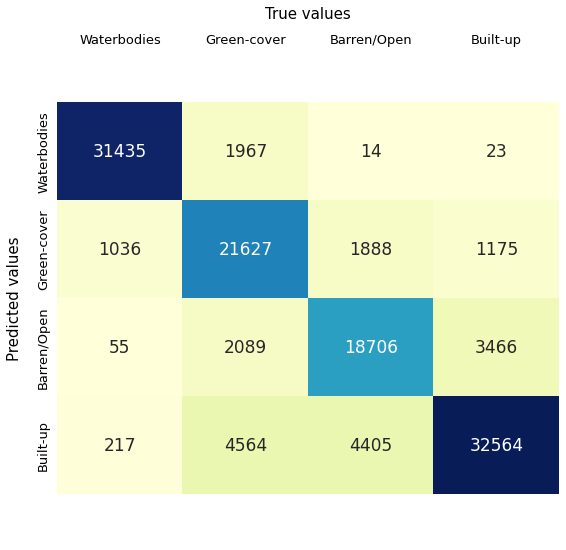

In [13]:
%%time
class_lables = ['Waterbodies', 'Green-cover', 'Barren/Open', 'Built-up']
import seaborn as sn
plt.figure(figsize = (9,9))
ax = sn.heatmap(cm_land[1:,1:], xticklabels=class_lables, yticklabels=class_lables, annot=True, fmt='g', cmap="YlGnBu", annot_kws={"fontsize":17}, cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, labeltop=True, left=False, bottom=False)
plt.yticks(va='center')
plt.ylabel('Predicted values', fontsize=15, labelpad = 15)
plt.xlabel('True values', fontsize=15, labelpad = 15)
ax.xaxis.set_label_position('top')

from sklearn.metrics import cohen_kappa_score
kappa_land = cohen_kappa_score(y_pred_land, ytest_land)
print(kappa_land)

In [14]:
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
Navi_Mumbai_LULC_prop = np.zeros([np.shape(Navi_Mumbai_maps)[0], 5])
Navi_Mumbai_pred_prop = np.zeros([1, 5])
for p in range(5):
    for k in range(np.shape(Navi_Mumbai_maps)[0]):
        Navi_Mumbai_LULC_prop[k,p] = (np.sum(Navi_Mumbai_maps[k]==p*17)/(np.shape(Navi_Mumbai_maps)[1]*np.shape(Navi_Mumbai_maps)[2]))*100
    Navi_Mumbai_pred_prop[0,p] = (np.sum(pred_2008==p*17)/(np.shape(Navi_Mumbai_maps)[1]*np.shape(Navi_Mumbai_maps)[2]))*100
print(Navi_Mumbai_LULC_prop)
print(Navi_Mumbai_pred_prop)

[[1.5055 32.4656 19.1672 28.5242 17.6797]
 [1.3000 27.4234 20.7695 27.1266 22.5172]
 [1.0672 27.1164 21.6203 23.2969 25.8031]
 [0.8234 26.7383 20.5188 22.2609 28.3187]
 [0.7547 25.5805 23.6305 19.5414 29.0844]]
[[0.7547 26.1242 20.0984 18.9969 32.6172]]


changes for BKC: [[1.3688 8.2722 18.3297 27.7128 38.0877]
 [1.3688 6.9431 14.0448 12.7356 58.6788]
 [1.3688 6.4670 10.7122 7.9944 67.2287]
 [1.3688 5.8917 9.6806 5.1974 71.6326]
 [1.3688 4.7213 9.1450 4.4237 74.1123]]
Wall time: 1.18 s


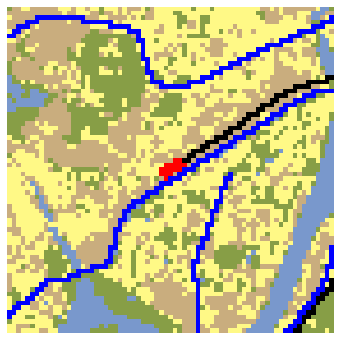

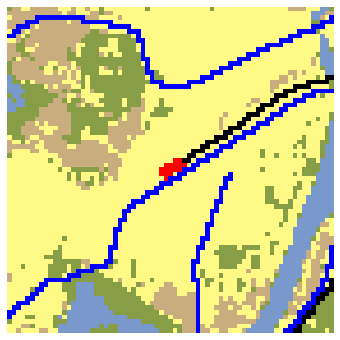

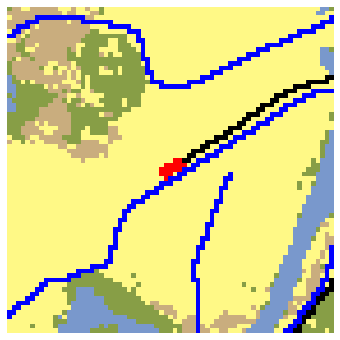

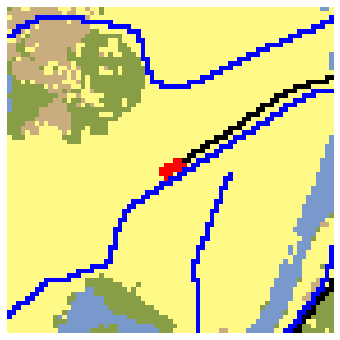

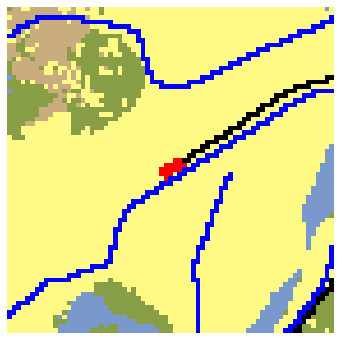

In [15]:
%%time
start_year = 2022
stations = ['BKC']

ymin = 0
ymax = 71
xmin = 0
xmax = 71

for station_name in stations:
    maps_2022 = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_LULC.tif'))
    roads_2022 = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_roads.tif'))
    stn_2022 = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_HSR_stn.tif'))

    BKC_maps = [maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax],maps_2022[ymin:ymax, xmin:xmax]]
    BKC_roads = [roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax],roads_2022[ymin:ymax, xmin:xmax]]
    BKC_station = [stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax],stn_2022[ymin:ymax, xmin:xmax]]

    BKC_rails = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_rail.tif'))
    BKC_DEM = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_DEM.tif'))[1:-1,1:-1]
    BKC_slope = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_slope.tif'))[1:-1,1:-1]
    BKC_elevations = np.empty(np.shape(BKC_maps))
    BKC_gradient = np.empty(np.shape(BKC_maps))

    BKC_all_roads = np.copy(BKC_roads[-1])
    BKC_all_stn = np.copy(BKC_station[-1])
    for i in range(np.shape(BKC_maps)[0]):
        BKC_maps[i][BKC_rails[ymin:ymax, xmin:xmax]==102] = 0
        BKC_maps[i][BKC_all_stn==85] = 0
        BKC_maps[i][BKC_station[i]==85] = 85
        BKC_maps[i][BKC_all_roads==119] = 0
        BKC_maps[i][BKC_roads[i]==119] = 119
        BKC_elevations[i] = BKC_DEM[ymin:ymax, xmin:xmax]
        BKC_gradient[i] = BKC_slope[ymin:ymax, xmin:xmax]
    
    BKC_LULC_prop = np.zeros([5, 5])
    for p in range(5):
        BKC_LULC_prop[0][p] = (np.sum(BKC_maps[0]==p*17)/(np.shape(BKC_maps)[1]*np.shape(BKC_maps)[2]))*100

    for i in range(1,5):
        neighbourhood_size = 15
        id_all = np.array([[1],[2],[3],[4]])
        d_max = (np.sqrt((ymax-ymin)**2 + (xmax-xmin)**2))*0.03
        stn_dist = np.ones(np.shape(BKC_station))*d_max
        stn_dist = distance_calculator(BKC_station, 85, 30, stn_dist)
        road_dist = np.ones(np.shape(BKC_roads))*d_max
        road_dist = distance_calculator(BKC_roads, 119, 30, road_dist)

        [self_water, self_green, self_barren, self_builtup, self_road] = intrinsic_values(BKC_maps, [17,34,51,68,119])
        [neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_road], neighbourhood_size)

        X1 = prepare_data(self_water[i-1:i])
        X2 = prepare_data(self_green[i-1:i])
        X3 = prepare_data(self_barren[i-1:i])
        X4 = prepare_data(self_builtup[i-1:i])
        X5 = prepare_data(neighbour_water[i-1:i])
        X6 = prepare_data(neighbour_green[i-1:i])
        X7 = prepare_data(neighbour_barren[i-1:i])
        X8 = prepare_data(neighbour_builtup[i-1:i])
        X9 = prepare_data(neighbour_road[i-1:i])
        X_stn = prepare_data(stn_dist[i-1:i])
        X10 = np.zeros(np.shape(X_stn))
        X10[X_stn<=0.25] = 1
        X_stn[X_stn<=0.25] = d_max
        X11 = np.zeros(np.shape(X_stn))
        X11[X_stn<=0.5] = 1
        X_stn[X_stn<=0.5] = d_max
        X12 = np.zeros(np.shape(X_stn))
        X12[X_stn<=1] = 1
        X_stn[X_stn<=1] = d_max
        X13 = np.zeros(np.shape(X_stn))
        X13[X_stn<=2] = 1
        X_stn[X_stn<=2] = d_max

        X_road = prepare_data(road_dist[i-1:i])
        X14 = np.zeros(np.shape(X_road))
        X14[X_road<=0.125] = 1
        X_road[X_road<=0.125] = d_max
        X15 = np.zeros(np.shape(X_road))
        X15[X_road<=0.25] = 1
        X_road[X_road<=0.25] = d_max
        X16 = np.zeros(np.shape(X_road))
        X16[X_road<=0.5] = 1
        X_road[X_road<=0.5] = d_max
        X17 = np.zeros(np.shape(X_road))
        X17[X_road<=1] = 1
        X_road[X_road<=1] = d_max

        X18 = prepare_data(BKC_gradient[i-1:i])
        X18[X18<=5] = 1
        X18[X18>5] = 0
        X19 = prepare_data(BKC_elevations[i-1:i])
        X19 = X19/100
        X0 = np.ones(np.shape(X1))

        xcheck = np.transpose([X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19])

        check_X = xcheck[:,1] + xcheck[:,2] + xcheck[:,3] + xcheck[:,4]
        index = np.where(check_X==0)
        xcheck[[index],:] = 0

        y_pred = classifier_land.predict(xcheck)
        map_new = np.reshape(y_pred,[(ymax-ymin),(xmax-xmin)])
        map_new[BKC_maps[i-1]==119] = 7
        map_new[BKC_all_stn==85] = 5
        #map_new[maps[i-1]==17] = 1
        map_new[BKC_maps[i-1]==68] = 4
        map_new = map_new*17
        BKC_maps[i] = map_new
        
        for p in range(5):
            BKC_LULC_prop[i][p] = (np.sum(BKC_maps[i]==p*17)/(np.shape(BKC_maps)[1]*np.shape(BKC_maps)[2]))*100

    print('changes for '+station_name +':', BKC_LULC_prop)

path = 'D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/'
for i in range(5):
    fig = plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(BKC_maps[i], cmap_new)
    
    plt.imsave(path+'with_'+str(station_name)+'_'+str(start_year+5*i)+'.png', BKC_maps[i], dpi=900, cmap = cmap_new)

In [16]:
years = [1988, 1993, 1998, 2003, 2008]
LULCs = ['water', 'green', 'barren', 'builtup', 'roads']
for i in years:
    globals()['maps_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/LULC/'+str(i)+'.tif'))
    globals()['roads_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_road_modified.tif'))
    globals()['stn_%s' % i] = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/'+str(i)+'_stn.tif'))
    
rail_line = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/New_stn_and_road/rail_line.tif'))
DEM = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_DEM.tif'))[1:-1,1:-1]
slope = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Navi_Mumbai_slope.tif'))[1:-1,1:-1]
height = np.array(Image.open(r'D:/GIS/Landsat/NaviMumbai/Other/Vashi_height_modified_new2.tif'))
height[height==0] = 100
height = height//10 + 1
height[height == 3] = 2
height[height==11] = 0
height[height>3] = 3

ymin = 547
ymax = 615
xmin = 35
xmax = 103

Vashi_maps = [maps_1988[ymin:ymax, xmin:xmax], maps_1993[ymin:ymax, xmin:xmax], maps_1998[ymin:ymax, xmin:xmax], maps_2003[ymin:ymax, xmin:xmax], maps_2008[ymin:ymax, xmin:xmax]]
Vashi_roads = [roads_1988[ymin:ymax, xmin:xmax], roads_1993[ymin:ymax, xmin:xmax], roads_1998[ymin:ymax, xmin:xmax], roads_2003[ymin:ymax, xmin:xmax], roads_2008[ymin:ymax, xmin:xmax]]
Vashi_stations = [stn_1988[ymin:ymax, xmin:xmax], stn_1993[ymin:ymax, xmin:xmax], stn_1998[ymin:ymax, xmin:xmax], stn_2003[ymin:ymax, xmin:xmax], stn_2008[ymin:ymax, xmin:xmax]]
Vashi_elevations = np.empty(np.shape(Vashi_maps))
Vashi_gradient = np.empty(np.shape(Vashi_maps))
Vashi_building_height = np.empty(np.shape(Vashi_maps))
Vashi_rails = rail_line[ymin:ymax, xmin:xmax]
Vashi_all_roads = np.copy(Vashi_roads[-1])
Vashi_all_stn = np.copy(Vashi_stations[-1])

for i in range(np.shape(Vashi_maps)[0]):
    Vashi_maps[i][Vashi_rails==102] = 0
    Vashi_maps[i][Vashi_all_stn==85] = 0
    Vashi_maps[i][Vashi_stations[i]==85] = 85
    Vashi_maps[i][Vashi_all_roads==119] = 0
    Vashi_maps[i][Vashi_roads[i]==119] = 119
    Vashi_elevations[i] = DEM[ymin:ymax, xmin:xmax]
    Vashi_gradient[i] = slope[ymin:ymax, xmin:xmax]
    Vashi_building_height[i] = np.multiply(height[ymin:ymax, xmin:xmax],Vashi_maps[i]==68)
    

In [17]:
neighbourhood_size = 15
id_all = np.array([[1],[2],[3],[4]])
d_max = 16

# proximity variables
stn_dist = np.ones(np.shape(Vashi_stations))*d_max
stn_dist = distance_calculator(Vashi_stations, 85, 30, stn_dist)
road_dist = np.ones(np.shape(Vashi_roads))*d_max
road_dist = distance_calculator(Vashi_roads, 119, 30, road_dist)

[self_water, self_green, self_barren, self_builtup, self_stn, self_road] = intrinsic_values(Vashi_maps, [17,34,51,68,85,119])
[neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_stn, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_stn, self_road], neighbourhood_size)

[self_low, self_mid, self_high] = intrinsic_values(Vashi_building_height, [1,2,3])
[neighbour_low, neighbour_mid, neighbour_high] = Cellular_Automata([self_low, self_mid, self_high], neighbourhood_size//3)

In [18]:
X_main = prepare_data(neighbour_builtup[0:4])

X6 = prepare_data(neighbour_low[0:4])
X7 = prepare_data(neighbour_mid[0:4])
X8 = prepare_data(neighbour_high[0:4])
X9 = prepare_data(neighbour_road[0:4])

X_stn = prepare_data(stn_dist[0:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1

X_road = prepare_data(road_dist[0:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1

X18 = prepare_data(Vashi_gradient[0:4])
X18[X18<=5] = 1
X18[X18>5] = 0
X19 = prepare_data(Vashi_elevations[0:4])
X19 = X19/100

X0 = np.ones(np.shape(X10))

Y1 = prepare_data(self_water[1:5])
Y2 = prepare_data(self_green[1:5])
Y3 = prepare_data(self_barren[1:5])
Y4 = prepare_data(self_builtup[1:5])
ytrain = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

# xtrain_h = np.transpose([X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,ytrain])
xtrain_h = np.transpose([X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
ytrain_h = prepare_data(Vashi_building_height[1:5])
xtrain_h[ytrain_h==0,:] = 0

In [19]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.3f}'.format})
classifier_height = LogisticRegression(solver='lbfgs', random_state = 0, max_iter = 10000, multi_class='ovr')
classifier_height.fit(xtrain_h, ytrain_h)
weights_height = classifier_height.coef_
print(weights_height[1:,:])

[[4.308 0.677 8.790 -5.005 -3.078 -1.386 0.502 0.766 0.687 2.353 1.805
  1.014 1.263 0.895]
 [5.073 0.226 -5.513 5.070 -6.637 0.999 1.943 1.807 1.829 -0.505 0.841
  1.176 1.219 1.601]
 [5.507 -0.522 -5.938 -3.490 8.563 0.069 1.356 1.441 1.535 1.174 -0.111
  0.267 0.128 -0.179]]
Wall time: 254 ms


In [20]:
X_main = prepare_data(neighbour_builtup[3:4])

X6 = prepare_data(neighbour_low[3:4])
X7 = prepare_data(neighbour_mid[3:4])
X8 = prepare_data(neighbour_high[3:4])
X9 = prepare_data(neighbour_road[3:4])

X_stn = prepare_data(stn_dist[3:4])
X10 = np.zeros(np.shape(X_stn))
X10[X_stn<=0.25] = 1
X_stn[X_stn<=0.25] = d_max
X11 = np.zeros(np.shape(X_stn))
X11[X_stn<=0.5] = 1
X_stn[X_stn<=0.5] = d_max
X12 = np.zeros(np.shape(X_stn))
X12[X_stn<=1] = 1
X_stn[X_stn<=1] = d_max
X13 = np.zeros(np.shape(X_stn))
X13[X_stn<=2] = 1

X_road = prepare_data(road_dist[3:4])
X14 = np.zeros(np.shape(X_road))
X14[X_road<=0.125] = 1
X_road[X_road<=0.125] = d_max
X15 = np.zeros(np.shape(X_road))
X15[X_road<=0.25] = 1
X_road[X_road<=0.25] = d_max
X16 = np.zeros(np.shape(X_road))
X16[X_road<=0.5] = 1
X_road[X_road<=0.5] = d_max
X17 = np.zeros(np.shape(X_road))
X17[X_road<=1] = 1

X18 = prepare_data(Vashi_gradient[3:4])
X18[X13<=5] = 1
X18[X13>5] = 0
X19 = prepare_data(Vashi_elevations[3:4])
X19 = X19/100

X0 = np.ones(np.shape(X10))

Y1 = prepare_data(self_water[4:5])
Y2 = prepare_data(self_green[4:5])
Y3 = prepare_data(self_barren[4:5])
Y4 = prepare_data(self_builtup[4:5])
ytest = np.matmul(np.transpose([Y1,Y2,Y3,Y4]), id_all).ravel()

# xtest_h = np.transpose([X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,ytest])
xtest_h = np.transpose([X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
ytest_h = prepare_data(Vashi_building_height[4:5]).ravel()
xtest_h[ytest_h==0,:] = 0

In [21]:
%%time
np.set_printoptions(formatter={'float_kind':'{0:0.4f}'.format})
ypred_h = classifier_height.predict(xtest_h)
cm_height = confusion_matrix(ypred_h, ytest_h)
print(cm_height)

acc_height = accuracy_score(ypred_h, ytest_h)
print(acc_height)
acu_height = (cm_height[1,1] + cm_height[2,2] + cm_height[3,3])/np.sum(cm_height[1:,1:])
print(acu_height)

[[3388    0    0    0]
 [   0  407   21   21]
 [   0   34  507   90]
 [   0    4   31  121]]
0.9565311418685121
0.837378640776699
Wall time: 7.96 ms


0.9002132893913812
Wall time: 50.9 ms


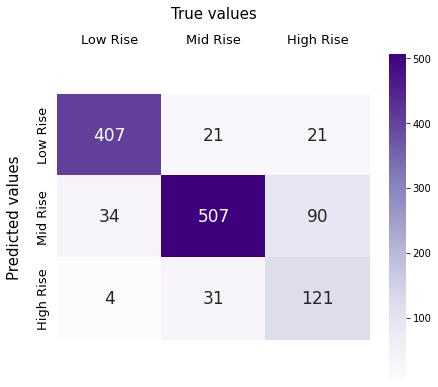

In [22]:
%%time
class_lables = ['Low Rise', 'Mid Rise', 'High Rise']
import seaborn as sn
plt.figure(figsize = (7,6))
ax = sn.heatmap(cm_height[1:,1:], xticklabels=class_lables, yticklabels=class_lables, annot=True, fmt='g', cmap="Purples", annot_kws={"fontsize":17}, cbar=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, labeltop=True, left=False, bottom=False)
plt.yticks(va='center')
plt.ylabel('Predicted values', fontsize=15, labelpad = 15)
plt.xlabel('True values', fontsize=15, labelpad = 15)
ax.xaxis.set_label_position('top')

from sklearn.metrics import cohen_kappa_score
kappa_height = cohen_kappa_score(ypred_h, ytest_h)
print(kappa_height)

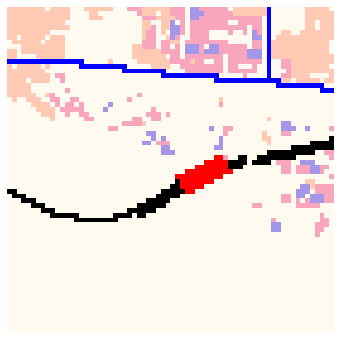

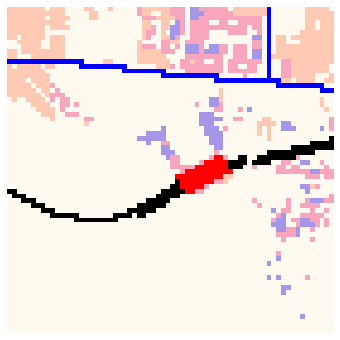

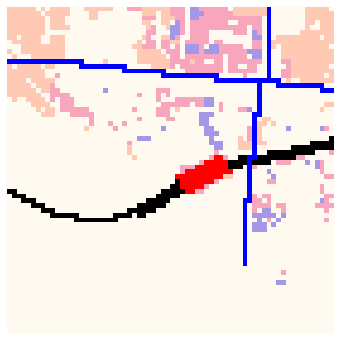

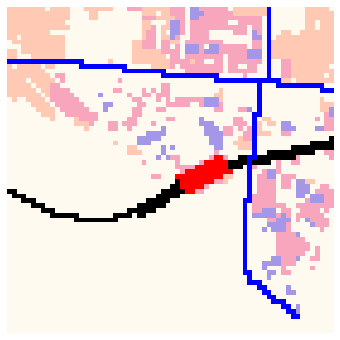

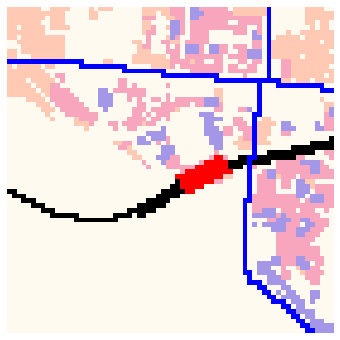

In [23]:
for i in range(5):
    Vashi_building_height[i][Vashi_rails==102] = 5
    Vashi_building_height[i][Vashi_all_stn==85] = 0
    Vashi_building_height[i][Vashi_stations[i]==85] = 4
    Vashi_building_height[i][Vashi_all_roads==119] = 0
    Vashi_building_height[i][Vashi_roads[i]==119] = 6
    plt.figure(figsize=(6,6))
    plt.imshow(Vashi_building_height[i], cmap_height)
    plt.grid(None)
    plt.axis('off')

plt.imsave('D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/Training Maps/Actual_1988.png', Vashi_building_height[0], dpi=900, cmap = cmap_height)
plt.imsave('D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/Training Maps/Actual_1993.png', Vashi_building_height[1], dpi=900, cmap = cmap_height)
plt.imsave('D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/Training Maps/Actual_1998.png', Vashi_building_height[2], dpi=900, cmap = cmap_height)
plt.imsave('D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/Training Maps/Actual_2003.png', Vashi_building_height[3], dpi=900, cmap = cmap_height)
plt.imsave('D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/Training Maps/Actual_2008.png', Vashi_building_height[4], dpi=900, cmap = cmap_height)


In [24]:
%%time
start_year = 2022
stations = ['BKC']

ymin = 0
ymax = 71
xmin = 0
xmax = 71

for station_name in stations:
    BKC_height = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/'+station_name+'/'+station_name+'_heights_new.tif'))
    BKC_height[BKC_height==0] = 100
    BKC_height = BKC_height//10 + 1
    BKC_height[BKC_height == 3] = 2
    BKC_height[BKC_height==11] = 0
    BKC_height[BKC_height>3] = 3
    BKC_building_height = np.empty(np.shape(BKC_maps))
    
    for i in range(np.shape(BKC_maps)[0]):
        BKC_maps[i][BKC_rails[ymin:ymax, xmin:xmax]==102] = 102
        BKC_maps[i][BKC_all_stn==85] = 85
        BKC_maps[i][BKC_all_roads==119] = 0
        BKC_maps[i][BKC_roads[i]==119] = 119
        BKC_elevations[i] = BKC_DEM[ymin:ymax, xmin:xmax]
        BKC_gradient[i] = BKC_slope[ymin:ymax, xmin:xmax]
        BKC_building_height[i] = np.multiply(BKC_height[ymin:ymax, xmin:xmax],BKC_maps[i]==68)
    
    BKC_height_prop = np.zeros([5, 4])
    for p in range(4):
        BKC_height_prop[0][p] = (np.sum(BKC_building_height[0]==p)/(np.shape(BKC_building_height)[1]*np.shape(BKC_building_height)[2]))*100
    
    for i in range(1,5):
        neighbourhood_size = 15
        id_all = np.array([[1],[2],[3],[4]])
        d_max = 16
        stn_dist = np.ones(np.shape(BKC_station))*d_max
        stn_dist = distance_calculator(BKC_station, 85, 30, stn_dist)
        road_dist = np.ones(np.shape(BKC_roads))*d_max
        road_dist = distance_calculator(BKC_roads, 119, 30, road_dist)

        [self_water, self_green, self_barren, self_builtup, self_road] = intrinsic_values(BKC_maps, [17,34,51,68,119])
        [neighbour_water, neighbour_green, neighbour_barren, neighbour_builtup, neighbour_road] = Cellular_Automata([self_water, self_green, self_barren, self_builtup, self_road], neighbourhood_size)
        
        [self_low, self_mid, self_high] = intrinsic_values(BKC_building_height, [1,2,3])
        [neighbour_low, neighbour_mid, neighbour_high] = Cellular_Automata([self_low, self_mid, self_high], neighbourhood_size//3)

        X1 = prepare_data(self_builtup[i:i+1])
        X_main = prepare_data(neighbour_builtup[i-1:i])
        
        X6 = prepare_data(neighbour_low[i-1:i])
        X7 = prepare_data(neighbour_mid[i-1:i])
        X8 = prepare_data(neighbour_high[i-1:i])
        X9 = prepare_data(neighbour_road[i-1:i])
        
        X_stn = prepare_data(stn_dist[i-1:i])
        X10 = np.zeros(np.shape(X_stn))
        X10[X_stn<=0.25] = 1
        X_stn[X_stn<=0.25] = d_max
        X11 = np.zeros(np.shape(X_stn))
        X11[X_stn<=0.5] = 1
        X_stn[X_stn<=0.5] = d_max
        X12 = np.zeros(np.shape(X_stn))
        X12[X_stn<=1] = 1
        X_stn[X_stn<=1] = d_max
        X13 = np.zeros(np.shape(X_stn))
        X13[X_stn<=2] = 1
        X_stn[X_stn<=2] = d_max

        X_road = prepare_data(road_dist[i-1:i])
        X14 = np.zeros(np.shape(X_road))
        X14[X_road<=0.125] = 1
        X_road[X_road<=0.125] = d_max
        X15 = np.zeros(np.shape(X_road))
        X15[X_road<=0.25] = 1
        X_road[X_road<=0.25] = d_max
        X16 = np.zeros(np.shape(X_road))
        X16[X_road<=0.5] = 1
        X_road[X_road<=0.5] = d_max
        X17 = np.zeros(np.shape(X_road))
        X17[X_road<=1] = 1
        X_road[X_road<=1] = d_max

        X18 = prepare_data(BKC_gradient[i-1:i])
        X18[X18<=5] = 1
        X18[X18>5] = 0
        X19 = prepare_data(BKC_elevations[i-1:i])
        X19 = X19/100
        X0 = np.ones(np.shape(X1))
        xcheck_height = np.transpose([X1,X0,X_main,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17])
        index2 = xcheck_height[:,0]
        print(np.shape(xcheck_height))
        xcheck_height[index2!=1,:] = 0
        print(np.shape(xcheck_height))
        
        y_pred_h = classifier_height.predict(xcheck_height[:,1:])
        
        map_new = np.reshape(y_pred_h,[(ymax-ymin),(xmax-xmin)])
        map_new[BKC_maps[i]==85] = 4
        map_new[BKC_maps[i]==102] = 5
        map_new[BKC_maps[i]==119] = 6
        map_new[BKC_maps[i]==0] = 0
        
        BKC_maps[i][BKC_rails[ymin:ymax, xmin:xmax]==102] = 102
        BKC_maps[i][BKC_all_stn==85] = 85
        BKC_maps[i][BKC_all_roads==119] = 0
        BKC_maps[i][BKC_roads[i]==119] = 119
        
        BKC_building_height[i] = map_new
        
        for p in range(4):
            BKC_height_prop[i][p] = (np.sum(BKC_building_height[i]==p)/(np.shape(BKC_building_height)[1]*np.shape(BKC_building_height)[2]))*100

    print('changes for '+station_name +':', BKC_height_prop)
    
    BKC_building_height[0][BKC_maps[i]==85] = 4
    BKC_building_height[0][BKC_maps[i]==102] = 5
    BKC_building_height[0][BKC_maps[i]==119] = 6
    BKC_building_height[0][BKC_maps[i]==0] = 0
    

(5041, 15)
(5041, 15)
(5041, 15)
(5041, 15)
(5041, 15)
(5041, 15)
(5041, 15)
(5041, 15)
changes for BKC: [[76.3737 6.9034 8.7086 8.0143]
 [33.7235 15.8302 24.6380 18.2107]
 [25.1736 18.6273 27.2962 21.3053]
 [20.7697 20.8094 27.8516 22.9716]
 [18.2900 22.0988 28.4071 23.6064]]
Wall time: 786 ms


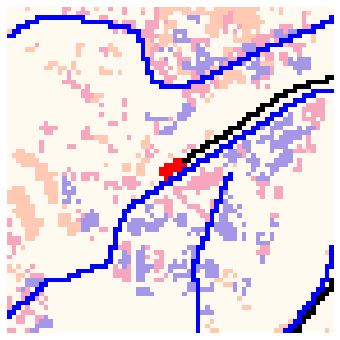

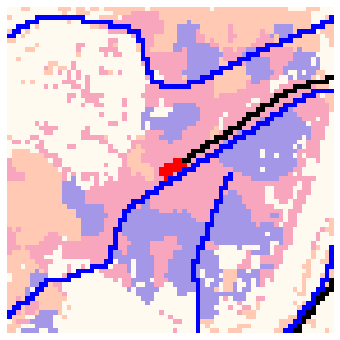

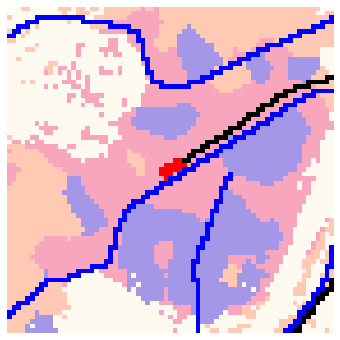

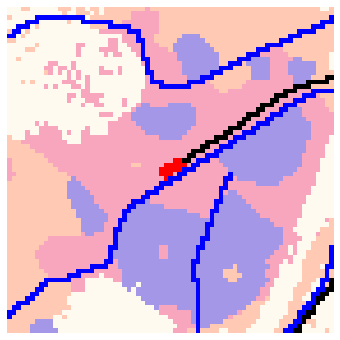

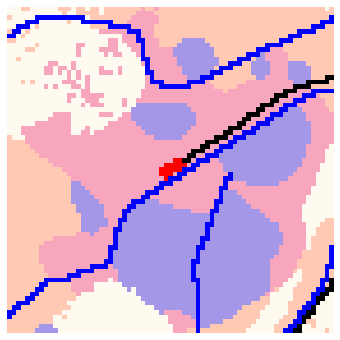

In [25]:
for i in range(5):
    fig = plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(BKC_building_height[i], cmap_height)

In [26]:
path = 'D:/GIS/Brownfield_HSR_stn/BKC/Projected_maps_new/'
for i in range(5):
    plt.imsave(path+'Building_Height_'+str(station_name)+'_'+str(start_year+5*i)+'.png', BKC_building_height[i], dpi=900, cmap = cmap_height)

In [27]:
BKC_height_initial = np.array(Image.open(r'D:/GIS/Brownfield_HSR_stn/BKC/BKC_heights_new.tif'))[0:71,0:71]

In [28]:
rn = np.random.exponential(20, 10000)
print(np.amax(rn))
rn1 = rn[(rn>=3)&(rn<=10)]
print(np.size(rn1))
rn2 = rn[(rn>=12)&(rn<=30)]
print(np.size(rn2))
rn3 = rn[(rn>=33)&(rn<=150)]
print(np.size(rn2))

238.91429702411813
2498
3269
3269


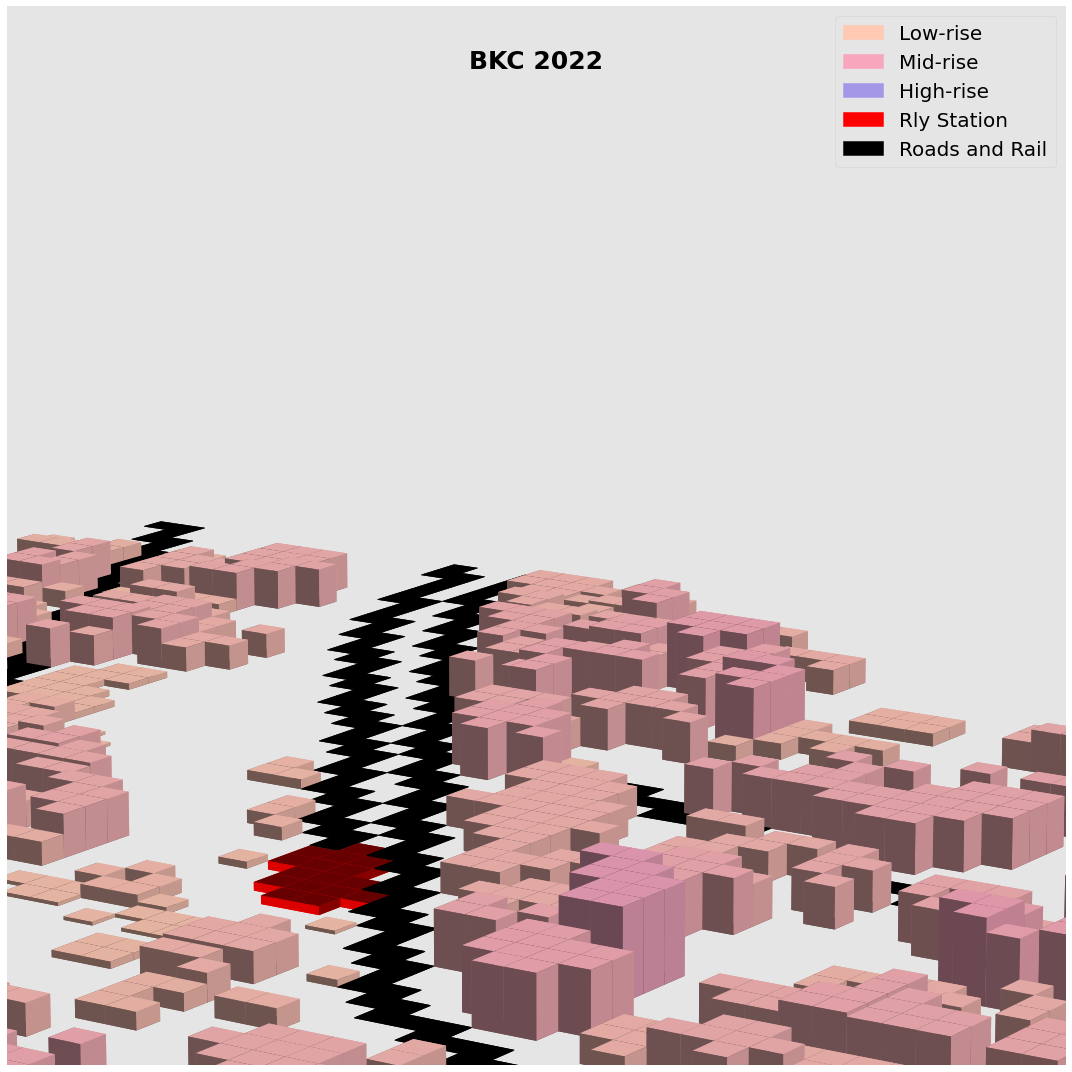

Wall time: 3.14 s


In [30]:
%%time

%matplotlib inline

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
style.use('ggplot')

fig = plt.figure(figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
fig.set_facecolor('white')
ax = plt.axes(projection='3d')
few_colors = ['#FFC9B3', '#F7A6BD', '#A597E8', '#FF0000', '#000000']
few_labels = ['Low-rise', 'Mid-rise', 'High-rise', 'Rly Station', 'Roads and Rail']

z3 = np.zeros(5041)
dx = np.ones(5041)
dy = np.ones(5041)

dz = np.zeros((5,5041))
colors_new = np.empty((5,5041), dtype='U7')

for k in range(np.shape(BKC_building_height)[0]):
    x3 = []
    y3 = []
    for i in range(np.shape(BKC_building_height[k])[0]):
        for j in range(np.shape(BKC_building_height[k])[1]):
            x3 = np.append(x3,[i])
            y3 = np.append(y3,[j])
            if BKC_building_height[k][i][j] == 1:
                if k==0:
                    c1 = (BKC_height_initial[i,j]//3)/10
                elif k>0 and dz[k-1,i*71+j]*30<=10:
                    c1 = (np.random.choice(rn1[rn1>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c1 = (np.random.choice(rn1)//3)/10
                dz[k,i*71+j] = c1
                colors_new[k,i*71+j] = '#FFC9B3'
            elif BKC_building_height[k][i][j] == 2:
                if k==0:
                    c2 = (BKC_height_initial[i,j]//3)/10
                elif k>0 and dz[k-1,i*71+j]*30<=30:
                    c2 = (np.random.choice(rn2[rn2>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c2 = (np.random.choice(rn2)//3)/10
                dz[k,i*71+j] = c2
                colors_new[k,i*71+j] = '#F7A6BD'
            elif BKC_building_height[k][i][j] == 3:
                if k==0:
                    c3 = (BKC_height_initial[i,j]//3)/10
                else:
                    c3 = (np.random.choice(rn3[rn3>=dz[k-1,i*71+j]*30])//3)/10
                dz[k,i*71+j] = c3
                colors_new[k,i*71+j] = '#A597E8'
            elif BKC_building_height[k][i][j] == 4:
                dz[k,i*71+j] = -0.25
            elif BKC_building_height[k][i][j] == 6 or BKC_building_height[k][i][j] == 5:
                dz[k,i*71+j] = 0.02
            else:
                dz[k,i*71+j] = 0.01

color1 = '#FFC9B3'
color2 = '#F7A6BD'
color3 = '#A597E8'

cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', [color1, color2, color3])
colors = np.zeros((5,5041,4))
for k in range(np.shape(colors)[0]):
    colors[k,:,:] = cmap(dz[k,:]/dz[4,:].max())
    for i in range(5041):
        if dz[k,i] == 0.02:
            colors[k,i,0:3] = 0
        elif dz[k,i] == 0.01:
            colors[k,i,:] = 0
        elif dz[k,i] == -0.25:
            colors[k,i,0] = 1
            colors[k,i,1:3] = 0
            
k = 0
light = mcolors.LightSource(azdeg=30, altdeg=45)
ax.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)

ax.axis('off')
ax.grid(False)

ax.azim = -56
ax.elev = 12
ax.dist = 8

ax.set_xlim3d(30,50)
ax.set_ylim3d(30,50)
ax.set_zlim3d(0,20)

fig.tight_layout()
plt.suptitle('BKC 2022', y=0.95, fontsize=25, fontweight='bold')

patches = [mpatches.Patch(color=col, label=lbl) for col, lbl in zip(few_colors, few_labels)]
ax.legend(handles=patches, fontsize=20)

plt.show()

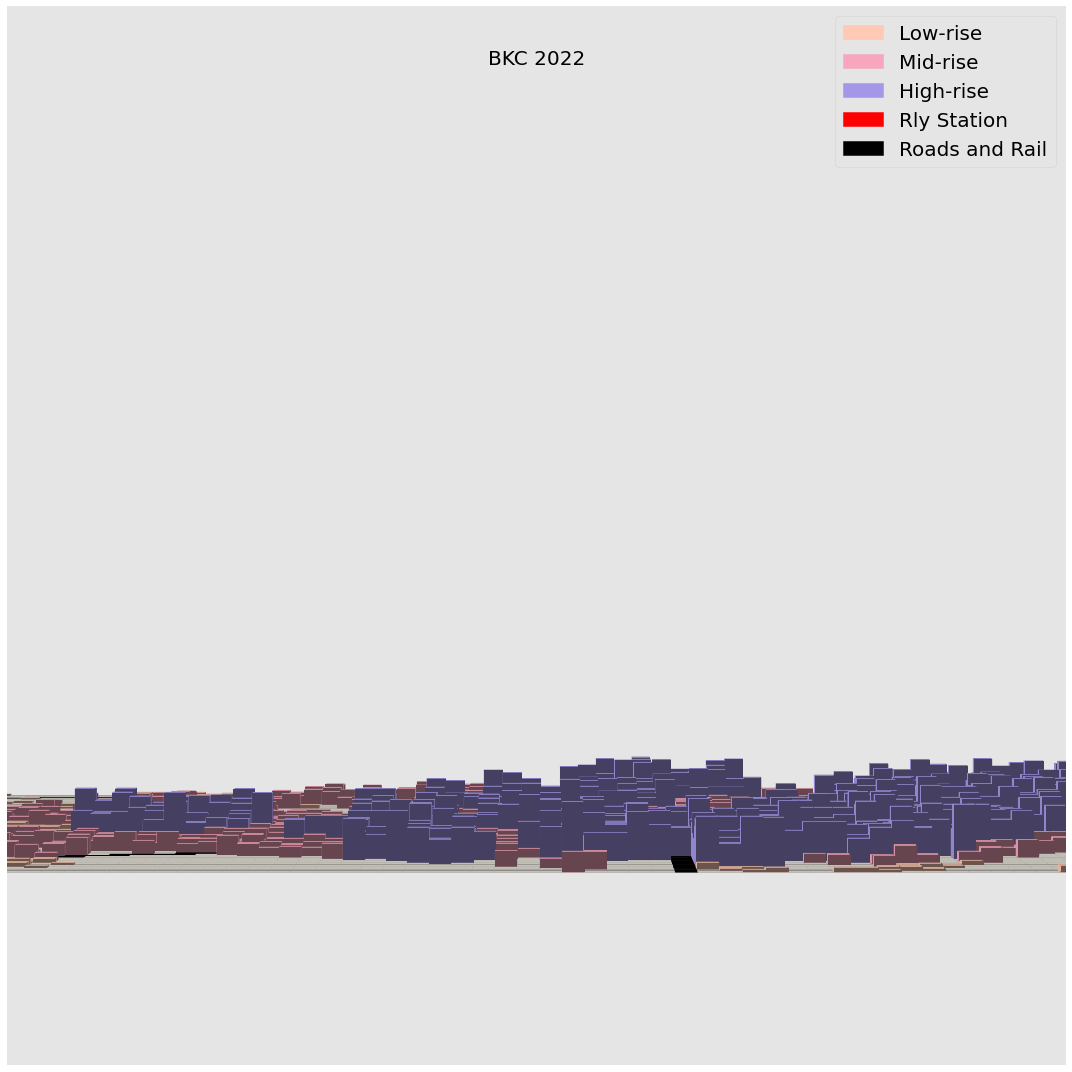

In [248]:
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
import matplotlib.patches as mpatches
style.use('ggplot')

fig = plt.figure(figsize=(15,15))
plt.rcParams["figure.autolayout"] = True
fig.set_facecolor('white')
ax = plt.axes(projection='3d')
few_colors = ['#FFC9B3', '#F7A6BD', '#A597E8', '#FF0000', '#000000']
few_labels = ['Low-rise', 'Mid-rise', 'High-rise', 'Rly Station', 'Roads and Rail']

z3 = np.zeros(5041)
dx = np.ones(5041)
dy = np.ones(5041)

dz = np.zeros((5,5041))
colors_new = np.empty((5,5041), dtype='U7')

for k in range(np.shape(BKC_building_height)[0]):
    x3 = []
    y3 = []
    for i in range(np.shape(BKC_building_height[k])[0]):
        for j in range(np.shape(BKC_building_height[k])[1]):
            x3 = np.append(x3,[i])
            y3 = np.append(y3,[j])
            if BKC_building_height[k][i][j] == 1:
                c1 = (np.random.choice(rn1)//3)/10
                dz[k,i*71+j] = c1
                colors_new[k,i*71+j] = '#FFC9B3'
            elif BKC_building_height[k][i][j] == 2:
                c2 = (np.random.choice(rn2)//3)/10
                dz[k,i*71+j] = c2
                colors_new[k,i*71+j] = '#F7A6BD'
            elif BKC_building_height[k][i][j] == 3:
                c3 = (np.random.choice(rn3)//3)/10
                dz[k,i*71+j] = c3
                colors_new[k,i*71+j] = '#A597E8'
            elif BKC_building_height[k][i][j] == 4:
                dz[k,i*71+j] = -0.25
                colors_new[k,i*71+j] = '#FF0000'
            elif BKC_building_height[k][i][j] == 6 or BKC_building_height[k][i][j] == 5:
                dz[k,i*71+j] = 0.01
                colors_new[k,i*71+j] = '#000000'
            else:
                dz[k,i*71+j] = 0.01
                colors_new[k,i*71+j] = '#FFFAF0'
    
ax.bar3d(x3, y3, z3, dx, dy, dz[0,:], alpha=1, color = colors_new[0,:], edgecolor='none')
    
ax.axis('off')
ax.grid(False)

ax.azim = 0
ax.elev = 30
ax.dist = 8

ax.set_xlim3d(0,71)
ax.set_ylim3d(0,71)
ax.set_zlim3d(0,71)

fig.tight_layout()
plt.suptitle('BKC 2022', y=0.95, fontsize=20)

patches = [mpatches.Patch(color=col, label=lbl) for col, lbl in zip(few_colors, few_labels)]
ax.legend(handles=patches, fontsize=20)

plt.show()

In [ ]:
%%time

from matplotlib.animation import FuncAnimation

k = 0

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111, projection='3d')
few_colors = ['#FFC9B3', '#F7A6BD', '#A597E8', '#FF0000', '#000000']
few_labels = ['Low-rise', 'Mid-rise', 'High-rise', 'Rly Station', 'Roads and Rail']

z3 = np.zeros(5041)
dx = np.ones(5041)
dy = np.ones(5041)

dz = np.zeros((5,5041))
colors_new = np.empty((5,5041), dtype='U7')

for k in range(np.shape(BKC_building_height)[0]):
    x3 = []
    y3 = []
    for i in range(np.shape(BKC_building_height[k])[0]):
        for j in range(np.shape(BKC_building_height[k])[1]):
            x3 = np.append(x3,[i])
            y3 = np.append(y3,[j])
            if BKC_building_height[k][i][j] == 1:
                if k>0 and dz[k-1,i*71+j]*30<=10:
                    c1 = (np.random.choice(rn1[rn1>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c1 = (np.random.choice(rn1)//3)/10
                dz[k,i*71+j] = c1
                colors_new[k,i*71+j] = '#FFC9B3'
            elif BKC_building_height[k][i][j] == 2:
                if k>0 and dz[k-1,i*71+j]*30<=30:
                    c2 = (np.random.choice(rn2[rn2>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c2 = (np.random.choice(rn2)//3)/10
                dz[k,i*71+j] = c2
                colors_new[k,i*71+j] = '#F7A6BD'
            elif BKC_building_height[k][i][j] == 3:
                if k>0:
                    c3 = (np.random.choice(rn3[rn3>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c3 = (np.random.choice(rn3)//3)/10
                dz[k,i*71+j] = c3
                colors_new[k,i*71+j] = '#A597E8'
            elif BKC_building_height[k][i][j] == 4:
                dz[k,i*71+j] = -0.25
                colors_new[k,i*71+j] = '#FF0000'
            elif BKC_building_height[k][i][j] == 6 or BKC_building_height[k][i][j] == 5:
                dz[k,i*71+j] = 0.01
                colors_new[k,i*71+j] = '#000000'
            else:
                dz[k,i*71+j] = 0.01
                colors_new[k,i*71+j] = '#FFFAF0'    
    

speed = 15 #fps
break1 = 27 #elevation_change
break2 = 87 #zoom_in
break3 = 187 #360 degree rotation
    
def update(num):
    ax1.clear()
    ax1.axis('off')
    ax1.set_frame_on(False)
    ax1.grid(False)
    patches = [mpatches.Patch(color=col, label=lbl) for col, lbl in zip(few_colors, few_labels)]
    ax1.legend(handles=patches, fontsize=20)
    if num<break1:
        ax1.view_init(elev=(90-(num*3)), azim=0)
        ax1.dist = 8
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(0,71)
        ax1.set_ylim(0,71)
        ax1.set_zlim(0,71)
        plt.suptitle('BKC 2022', y=0.85, fontsize=25)
    elif num<break2:
        ax1.view_init(elev=12, azim=(num-break1)*6)
        ax1.dist = 8
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(0,71)
        ax1.set_ylim(0,71)
        ax1.set_zlim(0,71)
        plt.suptitle('BKC 2022', y=0.85, fontsize=25)
    elif num<break3:
        ax1.view_init(elev=12, azim=0)
        ax1.dist = 8
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim((num-break2)*0.55,71+(num-break2)*0.05)
        ax1.set_ylim((num-break2)*0.35,71-(num-break2)*0.15)
        ax1.set_zlim(0,71-(num-384)*0.5)
        plt.suptitle('BKC 2022', y=0.85, fontsize=25)
    elif num<break3+2*speed:
        ax1.view_init(elev=12, azim=0)
        ax1.dist = 8
        k = 1
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(55,76)
        ax1.set_ylim(35,56)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2027', y=0.85, fontsize=25)
    elif num<break3+4*speed:
        ax1.view_init(elev=12, azim=0)
        ax1.dist = 8
        k = 2
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(55,76)
        ax1.set_ylim(35,56)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2032', y=0.85, fontsize=25)
    elif num<break3+6*speed:
        ax1.view_init(elev=12, azim=0)
        ax1.dist = 8
        k = 3
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(55,76)
        ax1.set_ylim(35,56)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2037', y=0.85, fontsize=25)
    elif num<break3+8*speed:
        ax1.view_init(elev=12, azim=0)
        ax1.dist = 8
        k = 4
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(55,76)
        ax1.set_ylim(35,56)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2042', y=0.85, fontsize=25)
    else:
        ax1.view_init(elev=12, azim=(num-(break3+8*speed))*6)
        ax1.dist = 8
        k = 4
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], alpha=1, color = colors_new[k,:], edgecolor='none')
        ax1.set_xlim(55,76)
        ax1.set_ylim(35,56)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2042', y=0.85, fontsize=25)
    
ani = FuncAnimation(fig, update, frames=range(2*break3+8*speed), repeat=True)

ani.save(path+'3D_files/Animation2.gif', writer='pillow', fps=speed)

In [31]:
%%time

z3 = np.zeros(5041)
dx = np.ones(5041)
dy = np.ones(5041)

dz = np.zeros((5,5041))
colors_new = np.empty((5,5041), dtype='U7')

for k in range(np.shape(BKC_building_height)[0]):
    x3 = []
    y3 = []
    for i in range(np.shape(BKC_building_height[k])[0]):
        for j in range(np.shape(BKC_building_height[k])[1]):
            x3 = np.append(x3,[i])
            y3 = np.append(y3,[j])
            if BKC_building_height[k][i][j] == 1:
                if k==0:
                    c1 = (BKC_height_initial[i,j]//3)/10
                elif k>0 and dz[k-1,i*71+j]*30<=10:
                    c1 = (np.random.choice(rn1[rn1>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c1 = (np.random.choice(rn1)//3)/10
                dz[k,i*71+j] = c1
                colors_new[k,i*71+j] = '#FFC9B3'
            elif BKC_building_height[k][i][j] == 2:
                if k==0:
                    c1 = (BKC_height_initial[i,j]//3)/10
                elif k>0 and dz[k-1,i*71+j]*30<=30:
                    c2 = (np.random.choice(rn2[rn2>=dz[k-1,i*71+j]*30])//3)/10
                else:
                    c2 = (np.random.choice(rn2)//3)/10
                dz[k,i*71+j] = c2
                colors_new[k,i*71+j] = '#F7A6BD'
            elif BKC_building_height[k][i][j] == 3:
                if k==0:
                    c1 = (BKC_height_initial[i,j]//3)/10
                else:
                    c3 = (np.random.choice(rn3[rn3>=dz[k-1,i*71+j]*30])//3)/10
                dz[k,i*71+j] = c3
                colors_new[k,i*71+j] = '#A597E8'
            elif BKC_building_height[k][i][j] == 4:
                dz[k,i*71+j] = -0.25
                colors_new[k,i*71+j] = '#FF0000'
            elif BKC_building_height[k][i][j] == 6 or BKC_building_height[k][i][j] == 5:
                dz[k,i*71+j] = 0.02
                colors_new[k,i*71+j] = '#000000'
            else:
                dz[k,i*71+j] = 0.01
                colors_new[k,i*71+j] = '#FFFAF0'


cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['#FFC9B3', '#F7A6BD', '#A597E8'])
colors = np.zeros((5,5041,4))
for k in range(np.shape(colors)[0]):
    colors[k,:,:] = cmap(dz[k,:]/dz[4,:].max())
    for i in range(5041):
        if dz[k,i] == 0.02:
            colors[k,i,0:3] = 0
        elif dz[k,i] == 0.01:
            colors[k,i,:] = 0
        elif dz[k,i] == -0.25:
            colors[k,i,0] = 1
            colors[k,i,1:3] = 0


Wall time: 644 ms


Wall time: 12min 22s


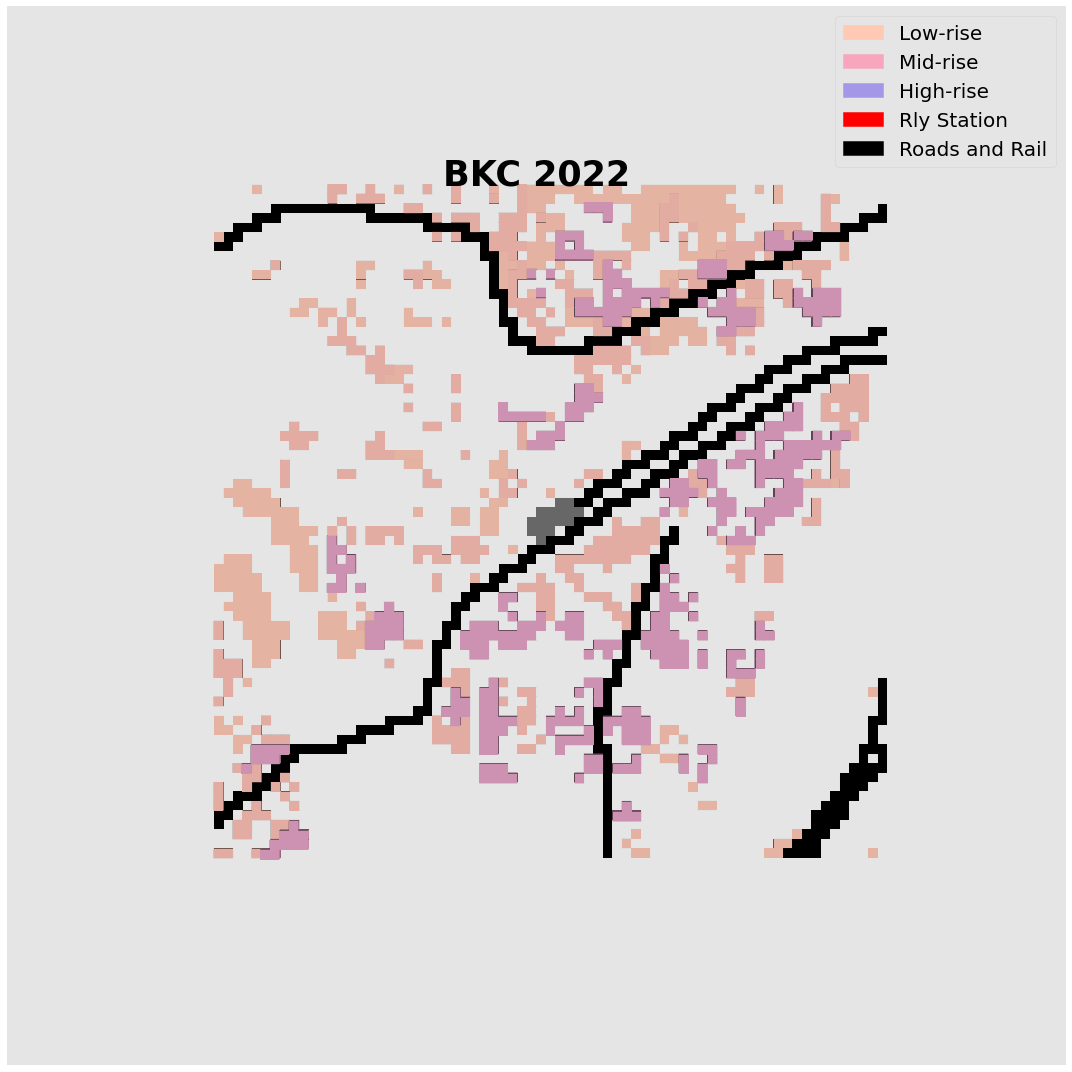

In [150]:
%%time
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111, projection='3d')
few_colors = ['#FFC9B3', '#F7A6BD', '#A597E8', '#FF0000', '#000000']
few_labels = ['Low-rise', 'Mid-rise', 'High-rise', 'Rly Station', 'Roads and Rail']

speed = 15 #fps
break1 = 40 #elevation_change
break2 = 50 + break1 + 6*speed #zoom_in
break3 = 401 #360 degree rotation

color1 = '#FFC9B3'
color2 = '#F7A6BD'
color3 = '#A597E8'

cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', [color1, color2, color3])

def update(num):
    ax1.clear()
    ax1.axis('off')
    ax1.set_frame_on(False)
    ax1.grid(False)
    patches = [mpatches.Patch(color=col, label=lbl) for col, lbl in zip(few_colors, few_labels)]
    ax1.legend(handles=patches, fontsize=20)
    
    if num<break1:
        ax1.view_init(elev=(90-(num*2)), azim=0)
        ax1.dist = 8
        k = 0
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        ax1.set_xlim(0,71)
        ax1.set_ylim(0,71)
        ax1.set_zlim(0,71)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
    elif num<break2:
        k = 0
        ax1.dist = 8
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        if num<(break1+2*speed):
            ax1.dist = 8
            ax1.view_init(elev=12, azim=0)
            ax1.set_xlim(0,71)
            ax1.set_ylim(0,71)
            ax1.set_zlim(0,71)
        elif num<(break2-4*speed):
            ax1.dist = 8
            ax1.view_init(elev=12, azim=0)
            ax1.set_xlim((num-(break1+2*speed))*0.9,71-(num-(break1+2*speed))*0.1)
            ax1.set_ylim((num-(break1+2*speed))*0.5,71-(num-(break1+2*speed))*0.5)
            ax1.set_zlim(0,71-(num-(break1+2*speed)*1.0))
        elif num<(break2-2*speed):
            ax1.dist = 8
            ax1.view_init(elev=12, azim=(num-(break2-4*speed))*-0.5)
            ax1.set_xlim(45,66)
            ax1.set_ylim(25,46)
            ax1.set_zlim(0,21)
        else:
            ax1.dist = 8
            ax1.view_init(elev=12, azim=-15)
            ax1.set_xlim(45,66)
            ax1.set_ylim(25,46)
            ax1.set_zlim(0,21)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
    elif num<break2+2*speed:
        ax1.view_init(elev=12, azim=-15)
        ax1.dist = 8
        k = 1
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2027', y=0.85, fontsize=35, fontweight='bold')
    elif num<break2+4*speed:
        ax1.view_init(elev=12, azim=-15)
        ax1.dist = 8
        k = 2
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2032', y=0.85, fontsize=35, fontweight='bold')
    elif num<break2+6*speed:
        ax1.view_init(elev=12, azim=-15)
        ax1.dist = 8
        k = 3
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2037', y=0.85, fontsize=35, fontweight='bold')
    else:
        ax1.view_init(elev=12, azim=-15)
        ax1.dist = 8
        k = 4
        colors = cmap(dz[k,:]/dz[4,:].max())
        for i in range(5041):
            if dz[k,i] == 0.02:
                colors[i,0:3] = 0
            elif dz[k,i] == 0.01:
                colors[i,:] = 0
            elif dz[k,i] == -0.25:
                colors[i,0:3] = 1
        light = mcolors.LightSource(azdeg=30, altdeg=45)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors, edgecolor='none', shade=True, lightsource=light)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)
        plt.suptitle('BKC 2042', y=0.85, fontsize=35, fontweight='bold')
    
ani = FuncAnimation(fig, update, frames=range(break2+8*speed), repeat=True)

ani.save(path+'3D_files/Animation_custom_cmap.gif', writer='pillow', fps=speed)

b1 0
b1 0
b1 1
b1 2
b1 3
b1 4
b1 5
b1 6
b1 7
b1 8
b1 9
b1 10
b1 11
b1 12
b1 13
b1 14
b1 15
b1 16
b1 17
b1 18
b1 19
b1 20
b1 21
b1 22
b1 23
b1 24
b1 25
b1 26
b1 27
b1 28
b1 29
b1 30
b1 31
b1 32
b1 33
b1 34
b1 35
b1 36
b1 37
b1 38
b1 39
b2 40
b2 41
b2 42
b2 43
b2 44
b2 45
b2 46
b2 47
b2 48
b2 49
b2 50
b2 51
b2 52
b2 53
b2 54
b2 55
b2 56
b2 57
b2 58
b2 59
b2 60
b2 61
b2 62
b2 63
b2 64
b2 65
b2 66
b2 67
b2 68
b2 69
b3 70
b3 71
b3 72
b3 73
b3 74
b3 75
b3 76
b3 77
b3 78
b3 79
b3 80
b3 81
b3 82
b3 83
b3 84
b3 85
b3 86
b3 87
b3 88
b3 89
b3 90
b3 91
b3 92
b3 93
b3 94
b3 95
b3 96
b3 97
b3 98
b3 99
b3 100
b3 101
b3 102
b3 103
b3 104
b3 105
b3 106
b3 107
b3 108
b3 109
b3 110
b3 111
b3 112
b3 113
b3 114
b3 115
b3 116
b3 117
b3 118
b3 119
b4 120
b4 121
b4 122
b4 123
b4 124
b4 125
b4 126
b4 127
b4 128
b4 129
b4 130
b4 131
b4 132
b4 133
b4 134
b4 135
b4 136
b4 137
b4 138
b4 139
b4 140
b4 141
b4 142
b4 143
b4 144
b4 145
b4 146
b4 147
b4 148
b4 149
b5 150
b5 151
b5 152
b5 153
b5 154
b5 155
b5 156
b5 157

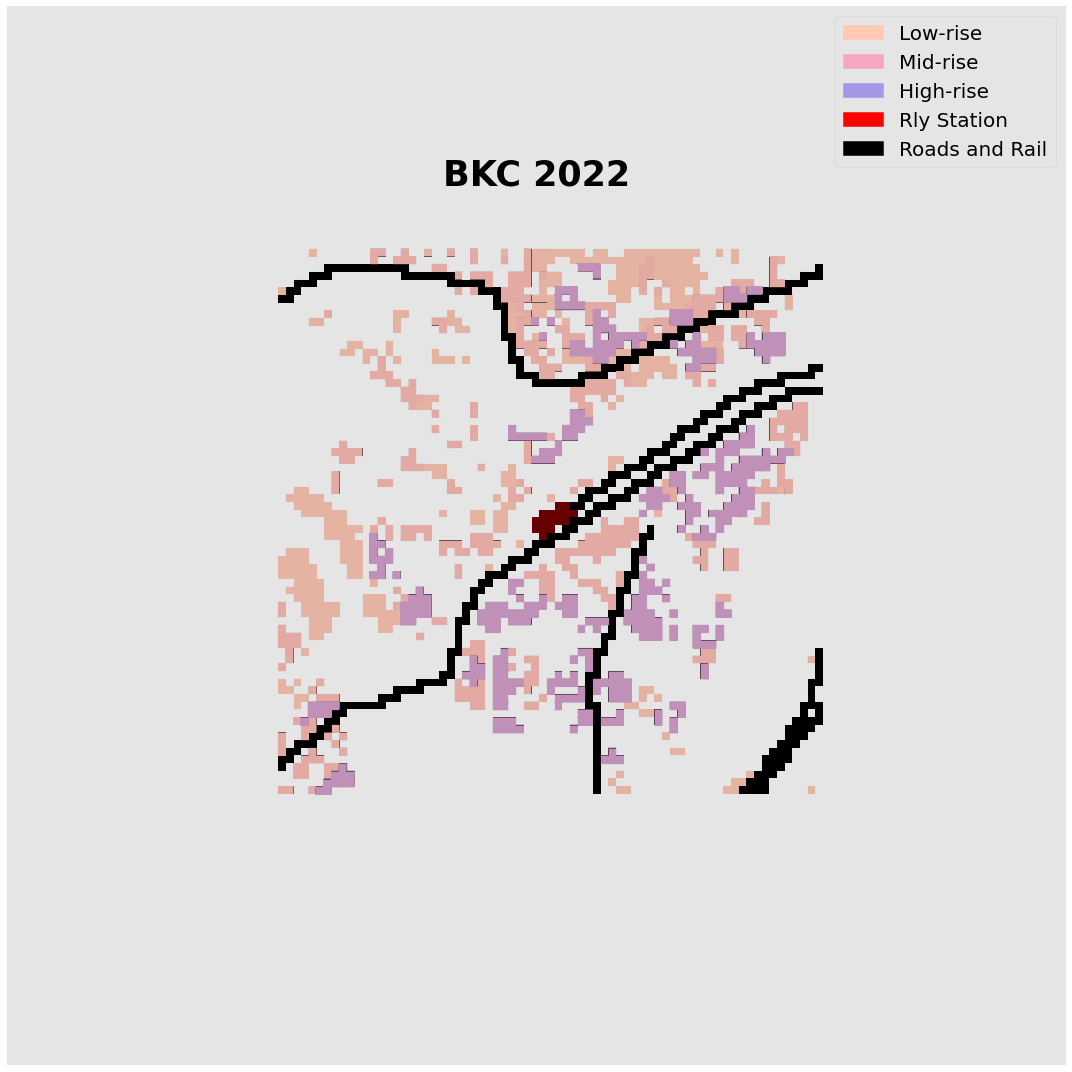

In [34]:
%%time
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111, projection='3d')
few_colors = ['#FFC9B3', '#F7A6BD', '#A597E8', '#FF0000', '#000000']
few_labels = ['Low-rise', 'Mid-rise', 'High-rise', 'Rly Station', 'Roads and Rail']

speed = 15 #fps
b1 = 40 #elevation_change
b2 = b1 + 2*speed #2_sec_pause
b3 = b2 + 50 #zoom_in
b4 = b3 + 2*speed

def update(num):
    ax1.dist = 8
    ax1.clear()
    ax1.axis('off')
    ax1.set_frame_on(False)
    ax1.grid(False)
    light = mcolors.LightSource(azdeg=30, altdeg=45)
    patches = [mpatches.Patch(color=col, label=lbl) for col, lbl in zip(few_colors, few_labels)]
    ax1.legend(handles=patches, fontsize=20)
    if num<b1:
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
        print('b1', num)
        ax1.view_init(elev=(90-(num*2)), azim=0)
        ax1.set_xlim(0,71)
        ax1.set_ylim(0,71)
        ax1.set_zlim(0,71)
    elif num<b2:
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
        print('b2', num)
        ax1.view_init(elev=12, azim=0)
        ax1.set_xlim(0,71)
        ax1.set_ylim(0,71)
        ax1.set_zlim(0,71)
    elif num<b3:
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
        print('b3', num)
        ax1.view_init(elev=12, azim=0)
        ax1.set_xlim((num-b2)*0.9,71-(num-b2)*0.1)
        ax1.set_ylim((num-b2)*0.5,71-(num-b2)*0.5)
        ax1.set_zlim(0,71-(num-b2)*1.0)
    elif num<b4:
        k = 0
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)
        plt.suptitle('BKC 2022', y=0.85, fontsize=35, fontweight='bold')
        print('b4', num)
        ax1.view_init(elev=12, azim=(num-b3)*-0.5)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)
    else:
        k = (num-b4)//(2*speed)
        print('b'+str(k+5), num)
        ax1.bar3d(x3, y3, z3, dx, dy, dz[k,:], color = colors[k,:], edgecolor='none', shade=True, lightsource=light)
        plt.suptitle('BKC '+str(2022+5*k), y=0.85, fontsize=35, fontweight='bold')
        ax1.view_init(elev=12, azim=-15)
        ax1.set_xlim(45,66)
        ax1.set_ylim(25,46)
        ax1.set_zlim(0,21)

ani = FuncAnimation(fig, update, frames=range(b4+10*speed), repeat=True)

ani.save(path+'3D_files/Animation_custom_cmap2.gif', writer='pillow', fps=speed)